<a href="https://colab.research.google.com/github/linhlinhle997/text2image-dcgan-bert/blob/develop/text2image_base_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import urllib.request
import zipfile
import numpy as np
import nltk
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter
from nltk.tokenize import word_tokenize
from tokenizers import Tokenizer, pre_tokenizers, trainers, models

import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torch.utils.data import Dataset, DataLoader
from transformers import PreTrainedTokenizerFast

## Download Dataset

In [2]:
def download_flickr8k(dataset_dir="Flickr8k"):
    os.makedirs(dataset_dir, exist_ok=True)

    urls = {
        "images": "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip",
        "captions": "https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip"
    }

    for key, url in urls.items():
        zip_path = os.path.join(dataset_dir, f"{key}.zip")
        extract_path = os.path.join(dataset_dir, key)

        if not os.path.exists(extract_path):
            urllib.request.urlretrieve(url, zip_path)

            with zipfile.ZipFile(zip_path, "r") as zip_ref:
                zip_ref.extractall(dataset_dir)

            os.remove(zip_path)


download_flickr8k()

In [3]:
CAPTIONS_FILE = "/content/Flickr8k/Flickr8k.token.txt"
IMAGE_DIR = "/content/Flickr8k/Flicker8k_Dataset"

captions, text = {}, []

with open(CAPTIONS_FILE, "r") as f:
    for line in f:
        parts = line.strip().split("\t")
        img_name = parts[0].split("#")[0]

        # Check if ".1" at the end of the file, then remove
        if img_name.endswith(".1"):
            img_name = img_name[:-2]

        #  Check if the file exists
        img_path = os.path.join(IMAGE_DIR, img_name)
        if not os.path.exists(img_path):
            print(f"File does not exist: {img_name}")
            continue

        caption = parts[1].lower()
        text.append(caption)

        if img_name not in captions:
            captions[img_name] = []
        captions[img_name].append(caption)

File does not exist: 2258277193_586949ec62.jpg
File does not exist: 2258277193_586949ec62.jpg
File does not exist: 2258277193_586949ec62.jpg
File does not exist: 2258277193_586949ec62.jpg
File does not exist: 2258277193_586949ec62.jpg


In [4]:
print(f"Total valid images: {len(captions)}")
print(f"Total captions collected: {len(text)}")
print("Sample captions: ")
dict(list(captions.items())[:5])

Total valid images: 8091
Total captions collected: 40455
Sample captions: 


{'1000268201_693b08cb0e.jpg': ['a child in a pink dress is climbing up a set of stairs in an entry way .',
  'a girl going into a wooden building .',
  'a little girl climbing into a wooden playhouse .',
  'a little girl climbing the stairs to her playhouse .',
  'a little girl in a pink dress going into a wooden cabin .'],
 '1001773457_577c3a7d70.jpg': ['a black dog and a spotted dog are fighting',
  'a black dog and a tri-colored dog playing with each other on the road .',
  'a black dog and a white dog with brown spots are staring at each other in the street .',
  'two dogs of different breeds looking at each other on the road .',
  'two dogs on pavement moving toward each other .'],
 '1002674143_1b742ab4b8.jpg': ['a little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .',
  'a little girl is sitting in front of a large painted rainbow .',
  'a small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .',
  't

## Data Preprocessing

### Tokenizer

In [5]:
# Create a word-based tokenizer
tokenizer = Tokenizer(models.WordLevel(unk_token="<unk>"))

tokenizer.pre_tokenizer = pre_tokenizers.Whitespace()

trainer = trainers.WordLevelTrainer(
    vocab_size=10000,
    min_frequency=2,
    special_tokens=["<pad>", "<unk>"]
)

# Train tokenizer on collected captions
tokenizer.train_from_iterator(text, trainer)

# Save the trained tokenizer
tokenizer.save("tokenizer.json")

In [6]:
# Load vocabulary from the tokenizer
vocab = tokenizer.get_vocab() # Extract vocabulary
word_to_id = lambda word: vocab.get(word, vocab["<unk>"]) # Function to get word ID

In [7]:
# Load tokenizer has been trained in PreTrainedTokenizerFast
tokenizer = PreTrainedTokenizerFast(
    tokenizer_file="tokenizer.json",
    unk_token="<unk>",
    pad_token="<pad>"
)

In [8]:
len(tokenizer)

5167

In [9]:
tokenizer("i go to school")

{'input_ids': [1427, 526, 21, 750], 'token_type_ids': [0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1]}

In [10]:
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

### Load Flickr8k dataset

In [11]:
class Flickr8kDataset(Dataset):
    def __init__(self, img_dir, captions, transform=None):
        self.img_dir = img_dir
        self.captions = captions
        self.img_names = list(captions.keys())
        self.transform = transform

    def __len__(self):
        return len(self.img_names)

    def __getitem__(self, idx):
        img_name = self.img_names[idx]
        img_path = os.path.join(self.img_dir, img_name)
        image = Image.open(img_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        caption = np.random.choice(self.captions[img_name]) # Select random caption
        encoded_caption = tokenizer(
            caption,
            padding="max_length",
            truncation=True,
            max_length=20,
            return_tensors="pt"
        )["input_ids"][0] # (1, 20) -> (20,)

        return {
            "image": image,
            "caption": encoded_caption
        }

In [12]:
transform = transforms.Compose([
    transforms.Resize((8, 8)),
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])

dataset = Flickr8kDataset(IMAGE_DIR, captions, transform)

In [13]:
sample = next(iter(dataset))
sample

{'image': tensor([[[-0.0824, -0.3412, -0.2471, -0.2706, -0.3647, -0.4196, -0.2549,
           -0.5294],
          [-0.2863, -0.5137, -0.1451, -0.2078, -0.4118, -0.4431, -0.2157,
           -0.5373],
          [-0.0902, -0.1765, -0.1608, -0.2471, -0.3490, -0.3255, -0.1059,
           -0.4667],
          [ 0.4510,  0.1529, -0.0824, -0.2471, -0.2863, -0.3333, -0.0902,
           -0.2235],
          [ 0.2157, -0.1059, -0.1529, -0.2235, -0.2392, -0.2627, -0.2314,
           -0.3490],
          [-0.5843, -0.7333, -0.5373, -0.3412, -0.2706, -0.2078, -0.0667,
           -0.3098],
          [-0.2549, -0.4431, -0.4902, -0.4824, -0.6863, -0.5686, -0.3176,
           -0.3333],
          [ 0.3255, -0.0353, -0.3255, -0.2863,  0.0196, -0.4118, -0.5529,
           -0.1216]],
 
         [[-0.0353, -0.4275, -0.3490, -0.3882, -0.5373, -0.5373, -0.3333,
           -0.5137],
          [-0.3333, -0.5922, -0.3255, -0.3647, -0.4980, -0.4902, -0.2784,
           -0.4824],
          [-0.2627, -0.3098, -0.3961, 

In [14]:
sample['image'].shape, sample['caption'].shape

(torch.Size([3, 8, 8]), torch.Size([20]))

### DataLoader

In [15]:
dataloader = DataLoader(dataset, batch_size=128, shuffle=True)
len(dataloader)

64

## Model

### Word Embeddings + LSTM

In [16]:
class embedding_text(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim):
        super(embedding_text, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(embed_dim, hidden_dim, batch_first=True)

    def forward(self, captions):
        embeds = self.embedding(captions)
        _, (hidden, _) = self.lstm(embeds)
        return hidden[-1]

### DCGAN Model

In [17]:
class Generator(nn.Module):
    def __init__(self, latent_dim, embed_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(latent_dim + embed_dim, 128 * 4 * 4), # (B, 320) -> (B, 512)
            nn.ReLU(True),

            nn.Unflatten(1, (128, 4, 4)), # (B, 512) -> (B, 128, 4, 4)

            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1), # (B, 128, 4, 4) -> (B, 64, 8, 8)
            nn.ReLU(True),

            nn.ConvTranspose2d(64, 3, 3, stride=1, padding=1), # (B, 64, 8, 8) -> (B, 3, 8, 8)
            nn.Tanh()
        )

    def forward(self, noise, caption_embed):
        x = torch.cat((noise, caption_embed), dim=1) # (B, 64) + (B, 256) = (B, 320)
        return self.model(x)


class Discriminator(nn.Module):
    def __init__(self, embed_dim):
        super(Discriminator, self).__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(3, 64, 3, stride=2, padding=1), # (B, 3, 8, 8) -> (B, 64, 4, 4)
            nn.LeakyReLU(0.2, inplace=True),

            nn.Conv2d(64, 128, 3 , stride=2, padding=1), # (B, 64, 4, 4) -> (B, 128, 2, 2)
            nn.LeakyReLU(0.2, inplace=True),

            nn.Flatten() # (B, 128, 2, 2) -> (B, 512)
        )

        self.fc = nn.Linear(512 + embed_dim, 1) # (B, 512) -> (B, 768)

    def forward(self, img, caption_embed):
        img_features = self.cnn(img)
        x = torch.cat((img_features, caption_embed), dim=1) # (B, 512) + (B, 256) = (B, 768)
        return torch.sigmoid(self.fc(x))

## Training

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator = Generator(64, 256).to(device)
discriminator = Discriminator(256).to(device)
text_embedding_model = embedding_text(len(tokenizer), 256, 256).to(device)

optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
criterion = nn.BCELoss()

In [19]:
batch_sample = next(iter(dataloader))

batch_sample['image'].shape, batch_sample['caption'].shape

(torch.Size([128, 3, 8, 8]), torch.Size([128, 20]))

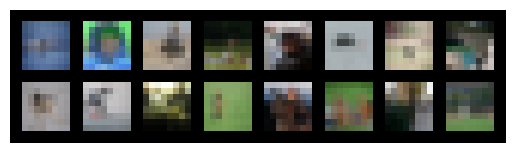

In [20]:
def show_grid(img):
    """Displays a grid of images."""
    npimg = img.cpu().numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

show_grid(torchvision.utils.make_grid(batch_sample["image"][:16], normalize=True))

In [21]:
caption_embeddings = text_embedding_model(batch_sample['caption'].to(device))
caption_embeddings.shape

torch.Size([128, 256])

In [22]:
noise = torch.randn(batch_sample['image'].size(0), 64, device=device)
fake_images = generator(noise, caption_embeddings)

noise.shape, fake_images.shape

(torch.Size([128, 64]), torch.Size([128, 3, 8, 8]))

In [23]:
for epoch in range(10):
    d_losses, g_losses = [], []
    for batch in dataloader:
        images = batch["image"].to(device)
        captions = batch["caption"].to(device)

        caption_embeddings = text_embedding_model(captions)
        noise = torch.randn(images.size(0), 64, device=device)

        fake_images = generator(noise, caption_embeddings)
        real_labels = torch.ones(images.size(0), 1, device=device)
        fake_labels = torch.zeros(images.size(0), 1, device=device)

        real_loss = criterion(
            discriminator(images, caption_embeddings),
            real_labels
        )
        fake_loss = criterion(
            discriminator(fake_images.detach(), caption_embeddings),
            fake_labels
        )
        '''    Detaches fake_images from the computation graph so that gradients
        do not flow back to the generator during Discriminator training.     '''

        d_loss = real_loss + fake_loss
        optimizer_D.zero_grad()
        d_loss.backward(retain_graph=True)
        optimizer_D.step()

        d_losses.append(d_loss.item())

        g_loss = criterion(discriminator(fake_images, caption_embeddings), real_labels)

        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        g_losses.append(g_loss.item())

    print(f"Epoch [{epoch+1}|5], D Loss: {d_loss.item()}, G_Loss: {g_loss.item()}")


Epoch [1|5], D Loss: 1.4547555446624756, G_Loss: 0.7388249039649963
Epoch [2|5], D Loss: 1.3988916873931885, G_Loss: 0.6821094155311584
Epoch [3|5], D Loss: 1.2624428272247314, G_Loss: 0.8335824608802795
Epoch [4|5], D Loss: 1.4130773544311523, G_Loss: 0.7029335498809814
Epoch [5|5], D Loss: 1.2550088167190552, G_Loss: 0.8182761669158936
Epoch [6|5], D Loss: 1.2532083988189697, G_Loss: 0.8602597117424011
Epoch [7|5], D Loss: 1.4373643398284912, G_Loss: 0.7452926635742188
Epoch [8|5], D Loss: 1.2845442295074463, G_Loss: 0.9641655683517456
Epoch [9|5], D Loss: 1.3179402351379395, G_Loss: 0.8817906975746155
Epoch [10|5], D Loss: 1.4315913915634155, G_Loss: 0.9042038321495056


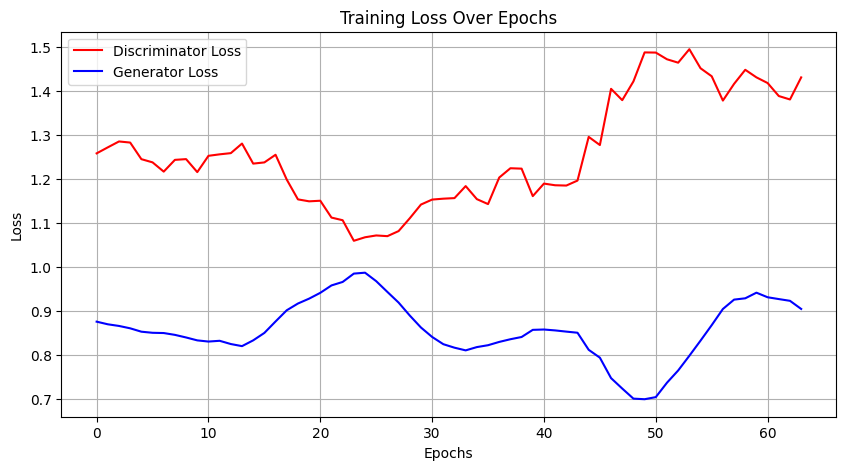

In [24]:
plt.figure(figsize=(10, 5))

plt.plot(d_losses, label="Discriminator Loss", color='red')
plt.plot(g_losses, label="Generator Loss", color='blue')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.grid()
plt.show()

## Prediction

Caption: a girl going into a wooden building .


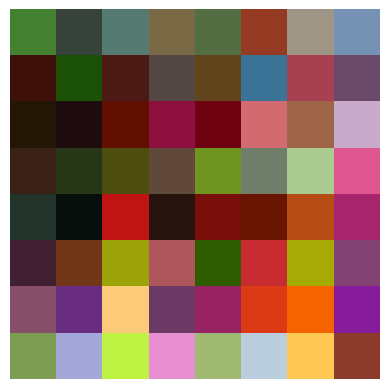

In [32]:
noise = torch.randn(size=(1, 64), device=device)
caption_tensor = sample["caption"].unsqueeze(0).to(device)
with torch.no_grad():
    caption_embedding = text_embedding_model(caption_tensor)
    generated_image = generator(noise, caption_embedding)

grid = torchvision.utils.make_grid(generated_image.cpu(), normalize=True)

original_caption = tokenizer.decode(sample["caption"], skip_special_tokens=True)
print(f"Caption: {original_caption}")
show_grid(grid)